## Biosppy 로 공황장애 예측하기

이번장에서는 biosppy 데이터로 공황장애를 예측해 보겠습니다.   

### 1. 데이터수집 

먼저, 데이터를 다음과 같이 수집합니다. 

In [58]:
import pandas as pd
# 데이터 로드 및 분할

df = pd.read_excel('biosppy_df.xlsx')

In [21]:
df

,age,sex,rmssd,mean_hr,r_peaks,target
0,81,female,0.0110,81.80,51,9.020004e-01
1,81,female,0.0048,86.25,165,7.790601e-01
2,81,female,0.0051,79.86,153,7.849090e-01
3,58,female,0.0091,78.87,150,5.183532e-01
4,63,male,0.0064,72.29,138,5.760572e-01
...,...,...,...,...,...,...
502,66,male,0.1777,117.27,233,4.987698e-01
503,66,male,0.0887,109.92,218,7.080713e-03
504,75,male,2.3180,44.69,88,1.281217e-08
505,75,male,0.0676,71.89,144,9.328596e-02


### 2. 데이터탐색

#### 기본정보

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507 entries, 0 to 506
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   age      507 non-null    int64  
 1   sex      507 non-null    object 
 2   rmssd    507 non-null    float64
 3   mean_hr  507 non-null    float64
 4   r_peaks  507 non-null    int64  
 5   target   507 non-null    float64
dtypes: float64(3), int64(2), object(1)
memory usage: 23.9+ KB


#### 기술통계

In [23]:
def descriptive_statistics(df):
    # General descriptive statistics for numerical columns
    print("Descriptive Statistics (Numerical Columns):")
    print(df.describe(), "\n")

    # Descriptive statistics for categorical columns (if any)
    categorical_cols = df.select_dtypes(include=['object', 'category'])
    if not categorical_cols.empty:
        print("Descriptive Statistics (Categorical Columns):")
        print(categorical_cols.describe(), "\n")

    # Display missing values
    print("Missing Values per Column:")
    print(df.isnull().sum(), "\n")

descriptive_statistics(df)    

Descriptive Statistics (Numerical Columns):
              age       rmssd     mean_hr     r_peaks        target
count  507.000000  507.000000  507.000000  507.000000  5.070000e+02
mean    56.293886    0.063383   75.076489  137.668639  5.967747e-01
std     13.979743    0.141056   15.424942   37.624374  2.806313e-01
min     17.000000    0.001200   36.850000   31.000000  1.281217e-08
25%     48.000000    0.008700   63.800000  120.000000  4.776136e-01
50%     57.000000    0.019400   73.820000  139.000000  6.623629e-01
75%     66.000000    0.066400   84.785000  159.500000  8.007122e-01
max     87.000000    2.318000  160.520000  319.000000  1.000000e+00 

Descriptive Statistics (Categorical Columns):
         sex
count    507
unique     2
top     male
freq     371 

Missing Values per Column:
age        0
sex        0
rmssd      0
mean_hr    0
r_peaks    0
target     0
dtype: int64 



#### 범주형 데이터를 수치형 데이터로 변환

In [66]:
from sklearn.preprocessing import LabelEncoder
# Object 타입 컬럼들을 Label Encoding
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

#### 데이터간 상관관계

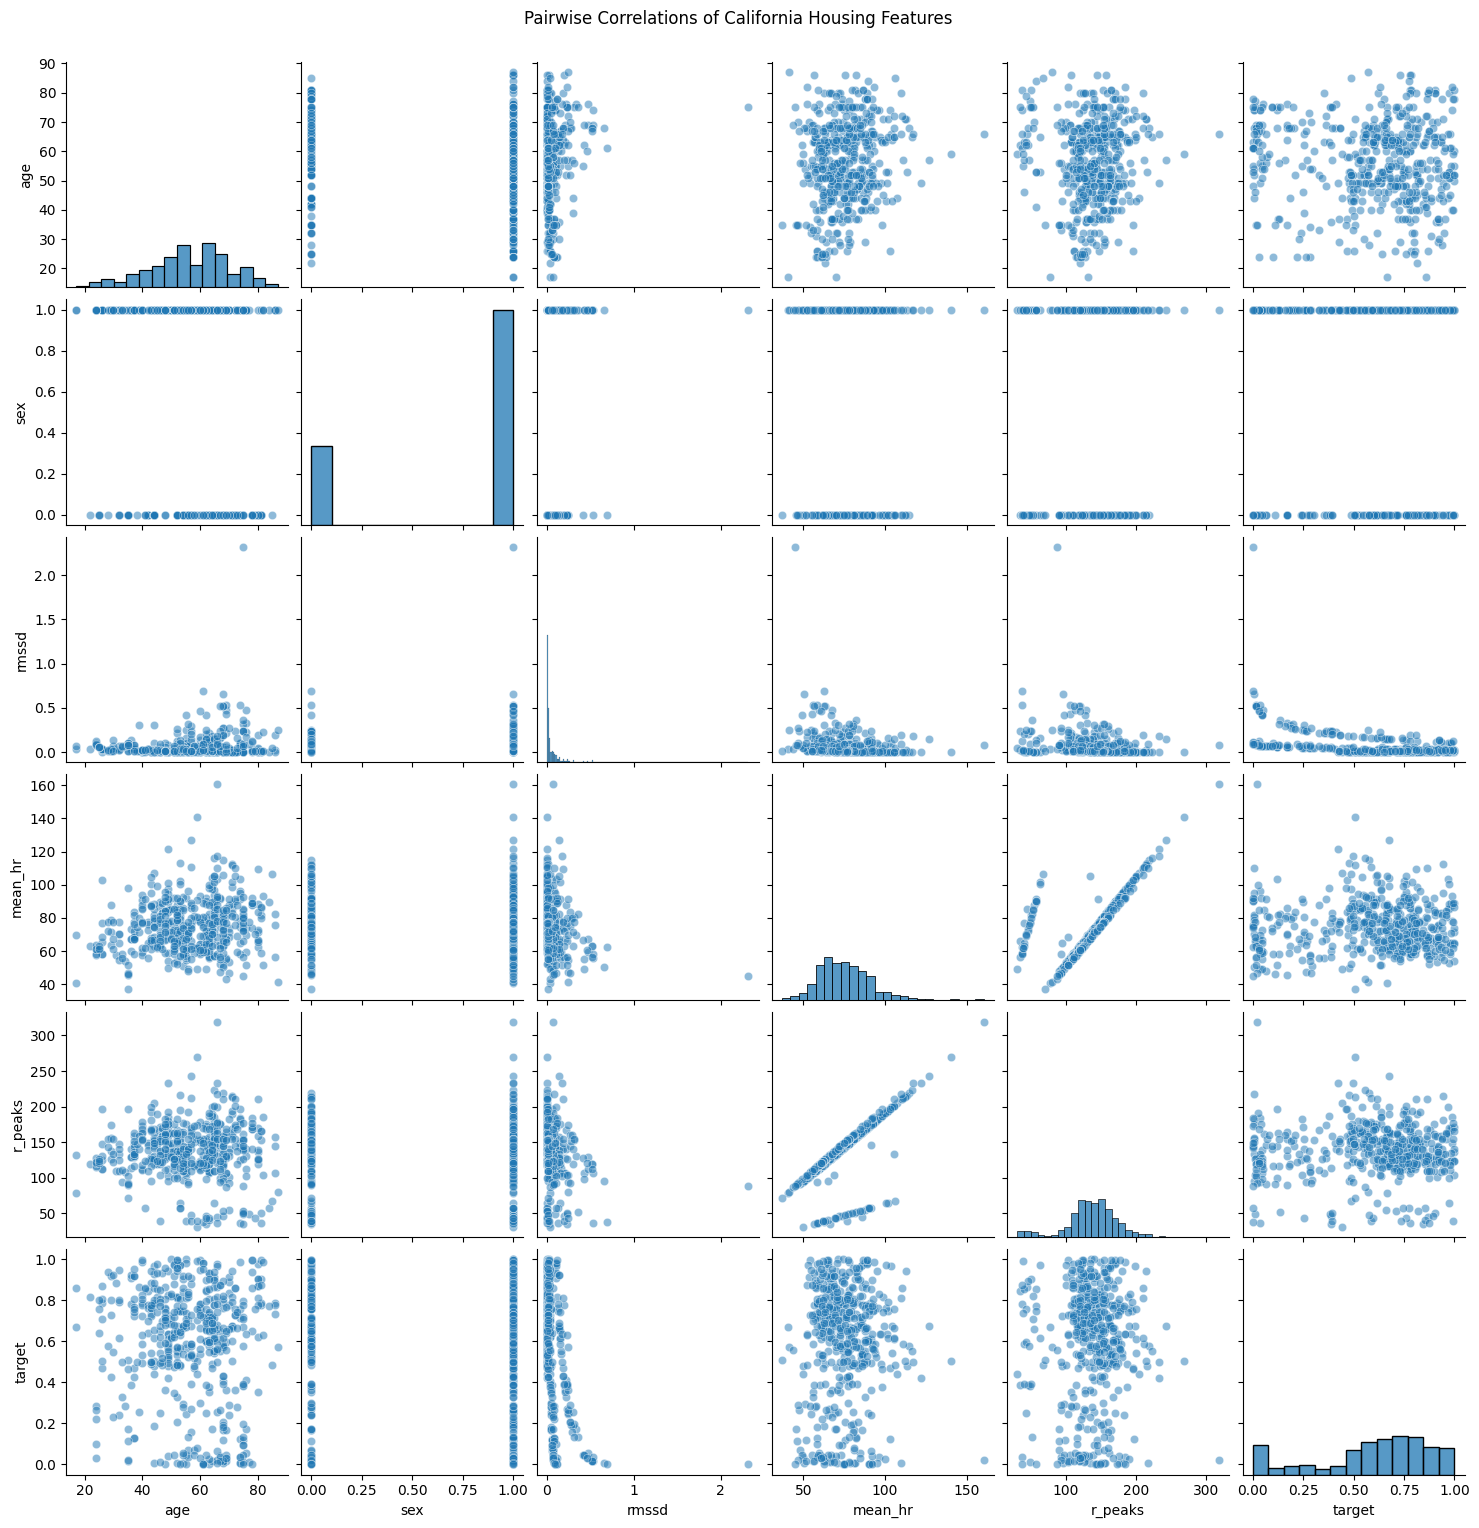

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_pairwise_correlations(df):
    sns.pairplot(df, height=2.5, plot_kws={'alpha': 0.5})
    plt.suptitle('Pairwise Correlations of Features', y=1.02)
    plt.show()

# Call the function to generate plots
plot_pairwise_correlations(df)

#### 이상치 시각화



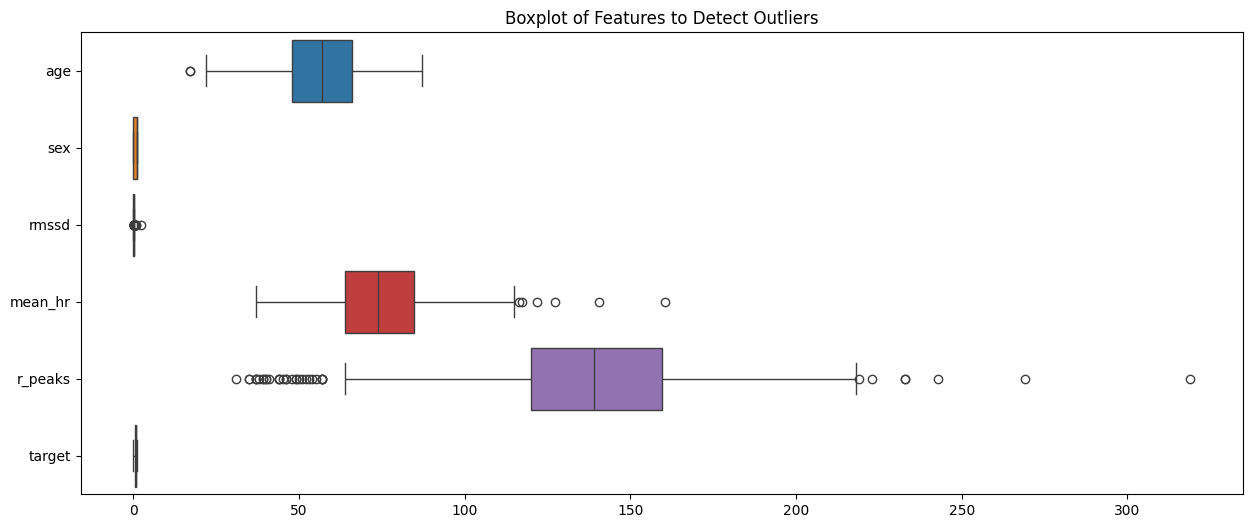

In [68]:
import seaborn as sns

# Create boxplots for all features
feature_df = pd.DataFrame(X, columns=df.columns)
plt.figure(figsize=(15, 6))
sns.boxplot(data=feature_df, orient="h")
plt.title("Boxplot of Features to Detect Outliers")
plt.show()

시각화 결과를 보면 다음과 같은 사실을 알 수 있습니다. 

* 수치형 변수의 scale 이 다양
* 몇몇 변수의 경우 outlier 존재
* r_peaks 와 mean_hr 간 상관관계 존재
* target 변수와 선형 상관관계를 갖는 변수 없음

따라서, 다음과 같은 데이터 전처리 전략을 세웁니다. 

1. clipping outlier 
2. 다중공선성 제거
3. 수치형 변수의 scale 정규화

### 3. 데이터 전처리

#### Clipping Outlier 
Outlier 를 lower_bound, upper_bound 값으로 치환

age 17 87 21.0 93.0
sex 0 1 -1.5 2.5
rmssd 0.0012 2.318 -0.07785 0.15295
mean_hr 36.85 160.52 32.3225 116.26249999999999
r_peaks 31 319 60.75 218.75


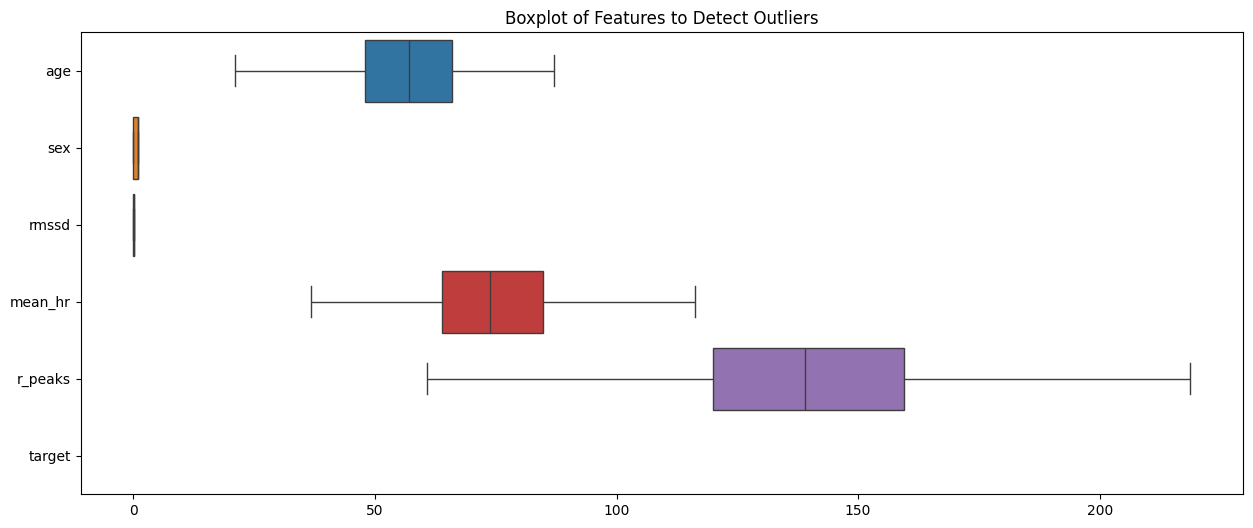

In [70]:
import numpy as np

def cap_outliers_with_min_max(data):
    """Cap outliers to the min and max values for each feature."""
    # Create a copy of the data to avoid modifying the original DataFrame
    data_capped = data.copy()

    # Iterate over each column to calculate IQR, bounds, and cap outliers
    for col in data.columns:
        Q1 = data[col].quantile(0.25)  # 1st quartile (25th percentile)
        Q3 = data[col].quantile(0.75)  # 3rd quartile (75th percentile)
        IQR = Q3 - Q1  # Interquartile range

        # Calculate lower and upper bounds for the column
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Get min and max values for the column
        min_val = data[col].min()
        max_val = data[col].max()
        
        print(col,min_val,max_val,lower_bound,upper_bound)

        # Replace values below the lower bound with the lower bound itself
        data_capped[col] = np.where(data[col] < lower_bound, lower_bound, data[col])

        # Replace values above the upper bound with the upper bound itself
        data_capped[col] = np.where(data[col] > upper_bound, upper_bound, data_capped[col])

    return data_capped

# Cap outliers in the dataset
X_capped = cap_outliers_with_min_max(X.drop("target",axis=1))

import seaborn as sns

# Create boxplots for all features
feature_df = pd.DataFrame(X_capped, columns=df.columns)
plt.figure(figsize=(15, 6))
sns.boxplot(data=feature_df, orient="h")
plt.title("Boxplot of Features to Detect Outliers")
plt.show()

#### 다중공선성 제거

**다중공선성(Multicollinearity)**은 독립 변수들 간의 상관관계가 높아 예측 모델(특히 회귀 모델)에서 개별 변수의 효과를 정확히 추정하기 어려운 문제입니다. 
다중공선성은 독립 변수들 간에 강한 상관관계가 있을 때 발생합니다. 이는 선형 회귀와 같은 모델에서는 문제가 될 수 있지만, EBM과 같은 비선형 모델에서는 다중공선성으로 인해 성능이 크게 저하되지 않습니다. 하지만, 두 변수의 영향이 중복되어 한 변수의 기여도를 정확히 해석하기 어려워질 수 있습니다. 따라서, 해석의 명확성을 위해 다중공선성을 줄이는 것이 좋습니다.

일반적으로 다중공선성은 선형 상관관계를 기준으로 탐지됩니다. 그러나 데이터가 비선형적일 경우, **선형 상관계수(VIF, Pearson 상관계수 등)**로는 이 문제를 제대로 탐지하지 못합니다.
Spearman 상관계수는 **순위 기반 상관계수(rank correlation)**로, 변수 간의 비선형적인 관계까지 포착할 수 있습니다.
다음 식에서 보는바와 같이 Spearman은 **두 변수의 순위(rank)**를 기반으로 상관관계를 계산하므로, Pearson 상관계수와 달리 비선형 관계에서도 유의미한 상관관계를 파악할 수 있습니다.

$$𝜌=1−\frac{6∑𝑑_𝑖^2}{𝑛(𝑛^2−1)}$$

$𝑑_𝑖$ : 두 변수의 각 데이터 쌍에 대한 순위 차이

$𝑛$: 데이터의 개수

Spearman 상관계수의 범위는 -1 ~ 1이며, 1은 완전한 양의 상관관계를, -1은 완전한 음의 상관관계를 의미합니다.

In [71]:
X = X_capped 

def print_spearman_correlation(data):
    """Print the Spearman correlation matrix for the dataset."""
    # Compute Spearman correlation matrix
    corr_matrix = data.corr(method='spearman')
    print("\nSpearman Correlation Matrix (absolute values):")
    print(corr_matrix.abs())

# Example usage
print_spearman_correlation(X)  # Print the correlation matrix


Spearman Correlation Matrix (absolute values):
              age       sex     rmssd   mean_hr   r_peaks
age      1.000000  0.183548  0.019155  0.159804  0.053053
sex      0.183548  1.000000  0.017455  0.111162  0.030849
rmssd    0.019155  0.017455  1.000000  0.431294  0.407848
mean_hr  0.159804  0.111162  0.431294  1.000000  0.852408
r_peaks  0.053053  0.030849  0.407848  0.852408  1.000000


correlation 이 0.8 이 넘는 feature 는 r_peaks 와 mean_hr입니다. 
r_peaks 와 mean_hr입니다 는 다음과 같은 합성 feature 로 대체합니다. 

In [72]:
X_capped['r_peaks_mean_hr'] = X_capped['r_peaks'] / X_capped['mean_hr']
X_capped.drop(['r_peaks', 'mean_hr'], axis=1, inplace=True)

#### 데이터 정규화

In [73]:
from sklearn.preprocessing import StandardScaler

# Apply StandardScaler
standard_scaler = StandardScaler()
X_standard_scaled = standard_scaler.fit_transform(X_capped)

# Create DataFrames to compare scaling results
df_standard = pd.DataFrame(X_standard_scaled, columns=X_capped.columns)
#df_robust = pd.DataFrame(X_robust_scaled, columns=data.feature_names)

# Summary statistics of scaled data
print("StandardScaler Summary:")
print(df_standard.describe().T)


StandardScaler Summary:
                 count          mean       std       min       25%       50%  \
age              507.0 -9.810255e-17  1.000988 -2.535932 -0.596798  0.049580   
sex              507.0  1.191245e-16  1.000988 -1.651648 -1.651648  0.605456   
rmssd            507.0  0.000000e+00  1.000988 -0.855974 -0.704625 -0.488700   
r_peaks_mean_hr  507.0  7.287618e-16  1.000988 -4.339828  0.196156  0.216336   

                      75%       max  
age              0.695958  2.204173  
sex              0.605456  0.605456  
rmssd            0.459755  2.206325  
r_peaks_mean_hr  0.249623  0.553525  


### 4. Baseline 모델 탐색

복잡한 모델을 구축하기 전에, 해당 문제를 해결할 수 있는 최소한의 성능 기준(baseline)을 찾기위해 regression 에 보편적으로 사용되는 Baseline 모델을 탐색합니다. 
Baseline 모델로는 설명력이 좋은 Linear Regression 과 Decision Tree Regression 을 사용합니다. EBM 은 최소 이 두 모델보다는 성능이 좋아야 합니다. 

또, 좋은 성능을 보여주지만 설명력이 약한 XGBoost, LGB, Random Forest 모델에 비해 얼마나 성능차이가 나는지를 확인합니다. 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[16:33:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 309
[LightGBM] [Info] Number of data points in the train set: 405, number of used features: 4
[LightGBM] [Info] Start training from score 0.593925
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

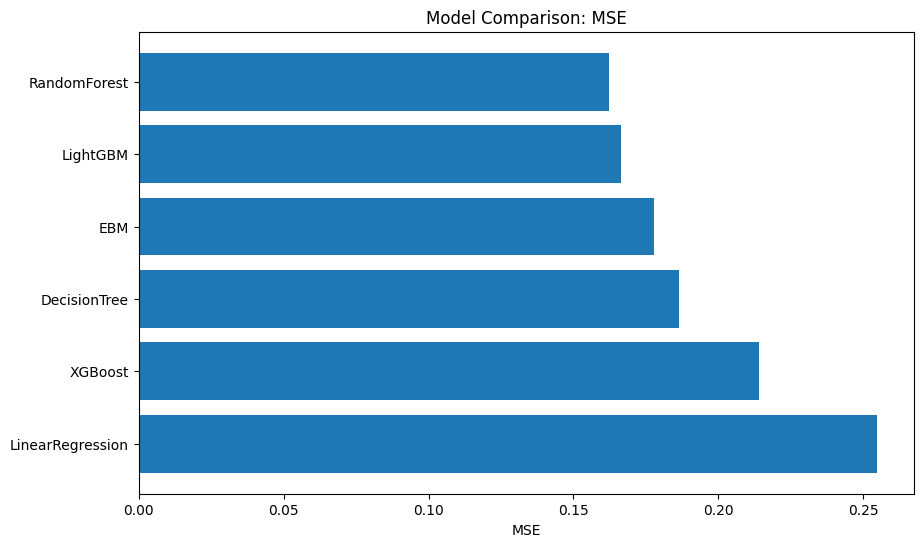

In [74]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from interpret.glassbox import ExplainableBoostingRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error, r2_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_standard, df.target, test_size=0.2, random_state=42)

# Initialize models
models = {
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, use_label_encoder=False, eval_metric='rmse'),
    "LightGBM": LGBMRegressor(random_state=42),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "LinearRegression": LinearRegression(),
    "EBM": ExplainableBoostingRegressor()
}

# Dictionary to store performance metrics
results = []

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    mse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store results
    results.append({"Model": name, "MSE": mse, "R^2": r2})

# Create a DataFrame to compare results
results_df = pd.DataFrame(results).sort_values(by="MSE", ascending=True)

# Display the results
print(results_df)

# Plot the comparison
plt.figure(figsize=(10, 6))
plt.barh(results_df['Model'], results_df['MSE'], align='center')
plt.xlabel('MSE')
plt.title('Model Comparison: MSE')
plt.gca().invert_yaxis()
plt.show()

### 5. Random Forest 모델 최적화


Random Forest는 여러 개의 결정 트리(Decision Tree)를 모아 구성된 앙상블 학습 모델입니다. 각각의 트리는 데이터를 독립적으로 학습하고 예측을 수행하며, 최종 예측은 다수결 투표 방식(분류)이나 평균(회귀)을 통해 결정됩니다. 이 방법은 단일 결정 트리의 과적합 문제를 줄이고, 성능과 일반화 능력을 높이는 데 효과적입니다.

랜덤 포레스트는 각 트리를 학습할 때 무작위로 샘플과 특성을 선택해 데이터에 대한 다양성을 제공합니다. 이로 인해, Random Forest는 데이터의 노이즈와 이상치에 강하고, 높은 예측 성능을 보입니다.

주요 하이퍼파라미터 설명
* n_estimators:

랜덤 포레스트에 포함되는 결정 트리의 개수를 나타냅니다.
일반적으로 많은 트리를 사용할수록 성능이 좋아지지만, 학습 시간도 길어집니다.
기본값은 100이며, 보통 100~1000 범위에서 조정됩니다.
* max_depth:

각 결정 트리의 최대 깊이를 설정합니다.
깊이가 깊을수록 모델이 복잡해지고, 과적합(overfitting) 가능성이 높아집니다.
데이터를 충분히 학습하도록 너무 깊게 설정하는 대신, 적절한 값을 찾아 모델의 복잡성을 조정합니다.
* min_samples_split:

노드를 분할하기 위해 필요한 최소 샘플 수를 지정합니다.
값이 클수록 분할을 덜 자주 하게 되어 모델이 덜 복잡해집니다.
기본값은 2입니다.
* min_samples_leaf:

각 리프 노드에 있어야 하는 최소 샘플 수입니다.
값을 높이면 과적합을 방지하고 모델의 일반화 성능을 높일 수 있습니다.
기본값은 1입니다.
* max_features:

각 트리가 분할 시 고려할 최대 특성 수를 지정합니다.
auto, sqrt, log2와 같은 옵션을 선택할 수 있습니다. 기본값은 분류의 경우 sqrt, 회귀의 경우 전체 특성 개수(auto)입니다.
작은 값을 선택하면 트리들 간의 다양성이 증가하여 일반화 성능이 좋아질 수 있습니다.
* bootstrap:

부트스트랩 샘플링(중복 허용 샘플링)을 사용할지 여부를 지정합니다.
True이면 중복 샘플링을 사용하며, 이를 통해 모델의 다양성을 증가시킬 수 있습니다. 기본값은 True입니다.
* random_state:

결과의 재현성을 위해 난수 생성 시드를 설정하는 파라미터입니다.
동일한 random_state를 사용하면 실행할 때마다 같은 결과를 얻을 수 있습니다.

최적의 성능을 얻기 위해 파라미터를 조정해야 하는데, 여기서는 Bayesian optimization 을 사용하겠습니다. 



In [53]:
import numpy as np
import pandas as pd
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from interpret.glassbox import ExplainableBoostingRegressor
import optuna


# Function to optimize hyperparameters for a given model
def optimize_model(trial, model_name, flag=0):
    if model_name == "RandomForest":
        n_estimators = trial.suggest_int("n_estimators", 50, 300)
        max_depth = trial.suggest_int("max_depth", 5, 50)
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)

    elif model_name == "XGBoost":
        n_estimators = trial.suggest_int("n_estimators", 50, 300)
        max_depth = trial.suggest_int("max_depth", 3, 50)
        learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
        model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth,
                             learning_rate=learning_rate, random_state=42, use_label_encoder=False)

    elif model_name == "LightGBM":
        n_estimators = trial.suggest_int("n_estimators", 50, 300)
        num_leaves = trial.suggest_int("num_leaves", 10, 100)
        learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
        model = LGBMRegressor(n_estimators=n_estimators, num_leaves=num_leaves,
                              learning_rate=learning_rate, random_state=42)

    elif model_name == "DecisionTree":
        max_depth = trial.suggest_int("max_depth", 5, 50)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
        model = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)

    elif model_name == "EBM":
        max_bins = trial.suggest_int("max_bins", 50, 300)
        learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
        max_rounds = trial.suggest_int("max_rounds", 10000, 30000)
        max_interaction_bins = trial.suggest_int("max_interaction_bins",32,128)
        model = ExplainableBoostingRegressor(max_bins=max_bins, learning_rate=learning_rate, max_interaction_bins=max_interaction_bins, max_rounds = max_rounds, random_state=42)

    else:  # LinearRegression has no hyperparameters to tune
        alpha = trial.suggest_loguniform('alpha', 1e-4, 100.0)
        model = Ridge(alpha=float(alpha))

    # Train the model

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)

    # Return RMSE as the objective to minimize
    if flag:
        return model, rmse
    else:
        return rmse

# Wrapper function to optimize each model's hyperparameters using Optuna
def run_optimization(model_name, n_trials=10):
    print(f"Optimizing {model_name}...")
    study = optuna.create_study(direction="minimize")
    try:
        study.optimize(lambda trial: optimize_model(trial, model_name), n_trials=n_trials)
        print(f"Best params for {model_name}: {study.best_params}")
    except Exception as e:
        print(f"Trial {model_name} failed: {e}")
        raise optuna.TrialPruned()
    return study.best_params

# Models to optimize
models = ["RandomForest"] #,"Ridge Regression", "EBM", "RandomForest", "XGBoost", "LightGBM", "DecisionTree"]

# Dictionary to store optimized models and results
results = []

# Train and evaluate each model with optimized hyperparameters
for model_name in models:
    try:
        best_params = run_optimization(model_name)

        model, _ = optimize_model(optuna.trial.FixedTrial(best_params), model_name, flag=1)  # Get the model object

         # Train with the best parameters
        y_pred = model.predict(X_test)
        mse = root_mean_squared_error(y_test, y_pred)  # RMSE
        r2 = r2_score(y_test, y_pred)

        # Store results
        results.append({"Model": model_name, "MSE": mse, "R^2": r2})
    except:
        results.append({"Model": model_name, "MSE": "NA", "R^2": "NA"})
# Create a DataFrame to compare results
results_df = pd.DataFrame(results).sort_values(by="MSE", ascending=True)

# Display the results
print(results_df)



[I 2024-11-10 16:02:42,185] A new study created in memory with name: no-name-6c35b18e-275a-4347-a0fe-6e488410443f


Optimizing RandomForest...


[I 2024-11-10 16:02:42,479] Trial 0 finished with value: 0.10083887671851992 and parameters: {'n_estimators': 201, 'max_depth': 13}. Best is trial 0 with value: 0.10083887671851992.
[I 2024-11-10 16:02:42,762] Trial 1 finished with value: 0.10078688164256064 and parameters: {'n_estimators': 240, 'max_depth': 35}. Best is trial 1 with value: 0.10078688164256064.
[I 2024-11-10 16:02:42,979] Trial 2 finished with value: 0.12528933130024744 and parameters: {'n_estimators': 276, 'max_depth': 5}. Best is trial 1 with value: 0.10078688164256064.
[I 2024-11-10 16:02:43,196] Trial 3 finished with value: 0.1033332253618562 and parameters: {'n_estimators': 215, 'max_depth': 10}. Best is trial 1 with value: 0.10078688164256064.
[I 2024-11-10 16:02:43,426] Trial 4 finished with value: 0.10072711171257845 and parameters: {'n_estimators': 205, 'max_depth': 29}. Best is trial 4 with value: 0.10072711171257845.
[I 2024-11-10 16:02:43,628] Trial 5 finished with value: 0.10124533607802653 and parameters:

Best params for RandomForest: {'n_estimators': 278, 'max_depth': 33}
          Model      MSE       R^2
0  RandomForest  0.10014  0.855506


### 6. 변수의 중요도 분석

Random Forest에서 변수의 중요도(Feature Importance)는 각 특성이 모델의 예측에 얼마나 기여하는지를 측정하는 지표입니다. 이는 모델이 예측을 수행할 때 어떤 특성이 가장 유용하게 작용하는지 파악하는 데 유용하며, 특히 해석이 중요한 문제에서 많이 사용됩니다.

[I 2024-11-10 16:09:20,606] A new study created in memory with name: no-name-3a1d56f9-4ab6-41b1-9563-50eb44397789


Optimizing RandomForest...


[I 2024-11-10 16:09:20,915] Trial 0 finished with value: 0.10194502342284636 and parameters: {'n_estimators': 229, 'max_depth': 11}. Best is trial 0 with value: 0.10194502342284636.
[I 2024-11-10 16:09:21,169] Trial 1 finished with value: 0.10125547738359399 and parameters: {'n_estimators': 183, 'max_depth': 23}. Best is trial 1 with value: 0.10125547738359399.
[I 2024-11-10 16:09:21,504] Trial 2 finished with value: 0.10189239077673062 and parameters: {'n_estimators': 217, 'max_depth': 15}. Best is trial 1 with value: 0.10125547738359399.
[I 2024-11-10 16:09:21,600] Trial 3 finished with value: 0.11316640032564232 and parameters: {'n_estimators': 104, 'max_depth': 7}. Best is trial 1 with value: 0.10125547738359399.
[I 2024-11-10 16:09:21,704] Trial 4 finished with value: 0.10326531562811478 and parameters: {'n_estimators': 91, 'max_depth': 19}. Best is trial 1 with value: 0.10125547738359399.
[I 2024-11-10 16:09:21,953] Trial 5 finished with value: 0.10079519281945823 and parameters:

Best params for RandomForest: {'n_estimators': 226, 'max_depth': 45}


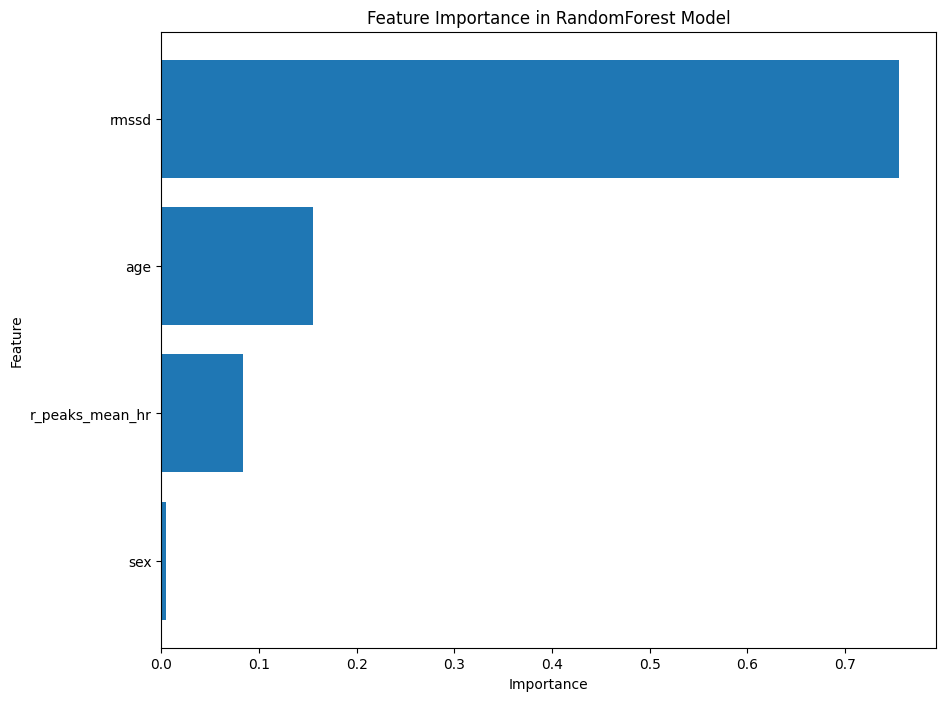

In [57]:
import matplotlib.pyplot as plt

model_name = "RandomForest"
best_params = run_optimization(model_name)

model, _ = optimize_model(optuna.trial.FixedTrial(best_params), model_name, flag=1)  # Get the model object

# 변수 중요도 추출
feature_importances = model.feature_importances_
features = X_train.columns

# 데이터프레임 생성하여 중요도 정렬
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 변수 중요도 시각화
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in RandomForest Model')
plt.gca().invert_yaxis()
plt.show()

### 8. 모델 안정성 검사

In [54]:
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
metrics = []

X = df_standard
y = df["target"]
for train_index, test_index in kf.split(X):

    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model, _ = optimize_model(optuna.trial.FixedTrial(best_params), "RandomForest", flag=1)
    
    y_pred = model.predict(X_test)
    
    mse = root_mean_squared_error(y_test, y_pred)
    metrics.append(mse)

print(f"Mean MSE: {np.mean(metrics):.4f}, Variance: {np.var(metrics):.4f}")


Mean MSE: 0.1459, Variance: 0.0006


In [55]:
import numpy as np

mean_mse = np.mean(metrics)
variance_mse = np.var(metrics)
std_mse = np.sqrt(variance_mse)

# Calculate Coefficient of Variance
cv = std_mse / mean_mse
print(f"Coefficient of Variation (CV): {cv:.4f}")

# Interpret the result
if cv < 0.1:
    print("The model is very stable.")
elif cv < 0.2:
    print("The model has acceptable stability.")
else:
    print("The model may be unstable.")

Coefficient of Variation (CV): 0.1636
The model has acceptable stability.


### 9. 모델 정확도 보고서 만들기

In [56]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, classification_report

# 확률 0.5를 기준으로 환자(1) 또는 정상(0)으로 분류
y_pred_binary = (y_pred >= 0.5).astype(int)
y_test_binary = (y_test >= 0.5).astype(int)

# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# 정확도, 정밀도, 재현율, F1 점수 계산
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

# 결과 출력
print("Confusion Matrix:\n", conf_matrix)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# 전체 성능 요약 보고서 출력
print("\nClassification Report:\n", classification_report(y_test_binary, y_pred_binary))

Confusion Matrix:
 [[16  6]
 [ 3 76]]
Accuracy: 0.9109
Precision: 0.9268
Recall: 0.9620
F1 Score: 0.9441

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.73      0.78        22
           1       0.93      0.96      0.94        79

    accuracy                           0.91       101
   macro avg       0.88      0.84      0.86       101
weighted avg       0.91      0.91      0.91       101

